# NDVI maps over the region of Mumbai (India) using Copernicus Land NDVI products

## Context

### Purpose

Demonstrate the usage of Copernicus Land NDVI product to assess the changes in the presence of live green vegetation over the region of Mumbai.

### Methodology approach
- Use NDVI data from the [Copernicus Global Land Service portal](https://land.copernicus.vgt.vito.be/PDF/portal/Application.html)
- Visualize NDVI monthly statistics (long term statistics between 1999 - 2019 and short term statistics 2015-2019
- Select a single point and compare NDVI from 2021 with NDVI long term statistics

### Highlights
- The presence of live green vegetation is done using NDVI ready data products from Copernicus Land 

### Contributions

#### Notebook
Anne Fouilloux (RSE), University of Oslo, annefou

#### Related Publication
- NDVI datasets from Copernicus Global Land Service over Mumbai (India) [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6882555.svg)](https://doi.org/10.5281/zenodo.6882555)

### Load libraries

In [1]:
pip install rioxarray wget

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import warnings
import pathlib
import glob
import tarfile
import wget

from datetime import datetime
import xarray as xr
import rioxarray
import hvplot.xarray

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

### Set project structure

In [3]:
warnings.filterwarnings('ignore')

In [4]:
WORKDIR_FOLDER = os.path.join(os.environ['HOME'], "datahub/Reliance/Mumbai/")
print("WORKDIR FOLDER: ", WORKDIR_FOLDER)

WORKDIR FOLDER:  /home/jovyan/datahub/Reliance/Mumbai/


In [5]:
INPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'input')
OUTPUT_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'output')
TOOL_DATA_DIR = os.path.join(WORKDIR_FOLDER, 'tool')

list_folders = [INPUT_DATA_DIR, OUTPUT_DATA_DIR, TOOL_DATA_DIR]

for folder in list_folders:
    pathlib.Path(folder).mkdir(parents=True, exist_ok=True)

### Download data

In [6]:
site_url = 'https://zenodo.org/record/6882555/files/Copernicus-Land-NDVI.tar.gz'

if (not pathlib.Path(site_url.split('/')[-1]).exists()):
    file_name = wget.download(site_url)
    print(file_name)

if (pathlib.Path(INPUT_DATA_DIR + '/Copernicus-Land-NDVI/').exists()):
    print("data available online")
else:
    print("untar data")
    data_tar = tarfile.open('Copernicus-Land-NDVI.tar.gz')
    data_tar.extractall(INPUT_DATA_DIR) # specify which folder to extract to
    data_tar.close()

Copernicus-Land-NDVI.tar.gz
data available online


### Load data
#### Long-term NDVI statistics

In [7]:
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

In [8]:
def stat_paths_to_datetimeindex(paths):
    return  [datetime.strptime('2019' + date.split('_')[-4].split('.')[0].split('-')[-1], '%Y%m%d') for date in paths]

In [9]:
ndvi_LTS = {}
for stat in ['max', 'min', 'mean', 'median', 'nobs', 'stdev']:
    dirtiff = INPUT_DATA_DIR + '/Copernicus-Land-NDVI/LTS/c_gls_NDVI-LTS-' + stat + '*.tiff'
    geotiff_list = glob.glob(dirtiff)
    geotiff_list.sort()
    tmp = xr.open_mfdataset(geotiff_list, parse_coordinates=True, mask_and_scale=True, engine='rasterio', preprocess = add_time_dim)
    variable = 'NDVI_' + stat
    tmp['time'] = stat_paths_to_datetimeindex(geotiff_list)
    tmp = tmp.rename({"band_data": variable, 'y': 'latitude', 'x':'longitude'})
    ndvi_LTS[stat] = tmp

In [10]:
ndvi_LTS

{'max': <xarray.Dataset>
 Dimensions:    (time: 36, band: 1, longitude: 112, latitude: 112)
 Coordinates:
   * time       (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-12-21
   * band       (band) int64 1
   * longitude  (longitude) float64 72.5 72.51 72.52 72.53 ... 73.47 73.48 73.49
   * latitude   (latitude) float64 19.5 19.49 19.48 19.47 ... 18.53 18.52 18.51
     crs        int64 0
 Data variables:
     NDVI_max   (time, band, latitude, longitude) float32 dask.array<chunksize=(1, 1, 112, 112), meta=np.ndarray>,
 'min': <xarray.Dataset>
 Dimensions:    (time: 36, band: 1, longitude: 112, latitude: 112)
 Coordinates:
   * time       (time) datetime64[ns] 2019-01-01 2019-01-11 ... 2019-12-21
   * band       (band) int64 1
   * longitude  (longitude) float64 72.5 72.51 72.52 72.53 ... 73.47 73.48 73.49
   * latitude   (latitude) float64 19.5 19.49 19.48 19.47 ... 18.53 18.52 18.51
     crs        int64 0
 Data variables:
     NDVI_min   (time, band, latitude, longitude) float32

### NDVI 200m for 2021 over Mumbai

In [11]:
dirtiff = INPUT_DATA_DIR + '/Copernicus-Land-NDVI/Mumbai/*/c_gls_NDVI300-NDVI_*.tiff'
geotiff_list = glob.glob(dirtiff)
geotiff_list.sort()
geotiff_list[0:5]

['/home/jovyan/datahub/Reliance/Mumbai/input/Copernicus-Land-NDVI/Mumbai/20210101/c_gls_NDVI300-NDVI_202101010000_CUSTOM_OLCI_V2.0.1.tiff',
 '/home/jovyan/datahub/Reliance/Mumbai/input/Copernicus-Land-NDVI/Mumbai/20210111/c_gls_NDVI300-NDVI_202101110000_CUSTOM_OLCI_V2.0.1.tiff',
 '/home/jovyan/datahub/Reliance/Mumbai/input/Copernicus-Land-NDVI/Mumbai/20210121/c_gls_NDVI300-NDVI_202101210000_CUSTOM_OLCI_V2.0.1.tiff',
 '/home/jovyan/datahub/Reliance/Mumbai/input/Copernicus-Land-NDVI/Mumbai/20210201/c_gls_NDVI300-NDVI_202102010000_CUSTOM_OLCI_V2.0.1.tiff',
 '/home/jovyan/datahub/Reliance/Mumbai/input/Copernicus-Land-NDVI/Mumbai/20210211/c_gls_NDVI300-NDVI_202102110000_CUSTOM_OLCI_V2.0.1.tiff']

In [12]:
ndvi = xr.open_mfdataset(geotiff_list, parse_coordinates=True, mask_and_scale=True, engine='rasterio', preprocess = add_time_dim)

In [13]:
def NDVI_paths_to_datetimeindex(paths):
    return  [datetime.strptime(date.split('_')[-4].split('.')[0], '%Y%m%d%f') for date in paths]

In [14]:
variable = 'NDVI'
ndvi['time'] = NDVI_paths_to_datetimeindex(geotiff_list)
ndvi = ndvi.rename({"band_data": variable, 'y': 'latitude', 'x':'longitude'})

In [15]:
ndvi

<xarray.Dataset>
Dimensions:    (time: 36, band: 1, longitude: 336, latitude: 336)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-11 ... 2021-12-21
  * band       (band) int64 1
  * longitude  (longitude) float64 72.5 72.5 72.51 72.51 ... 73.49 73.49 73.5
  * latitude   (latitude) float64 19.5 19.5 19.49 19.49 ... 18.51 18.51 18.5
    crs        int64 0
Data variables:
    NDVI       (time, band, latitude, longitude) float32 dask.array<chunksize=(1, 1, 336, 336), meta=np.ndarray>

## Outputs

### Plot Long-term NDVI statistics over the downloaded geographical area

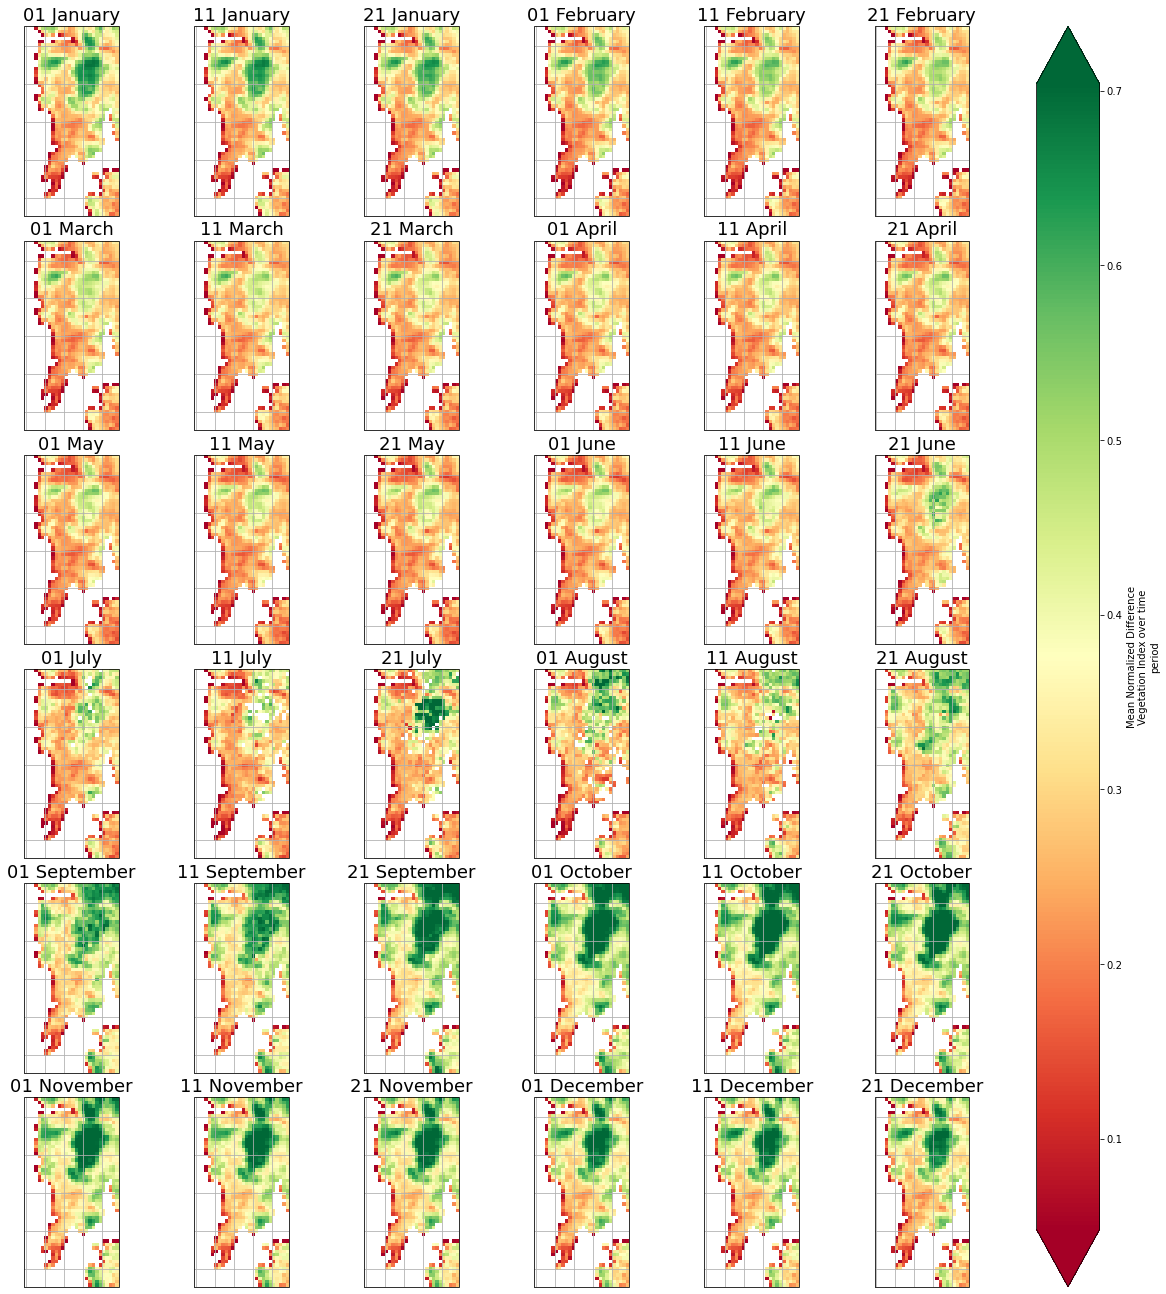

In [16]:
stat = 'mean'
ndvi_stat = ndvi_LTS[stat]
variable = 'NDVI_' + stat

proj_plot = ccrs.PlateCarree()

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)

p = ndvi_stat.where(ndvi_stat[variable] < ndvi_stat[variable].max())[variable].sel(latitude=slice(19.35, 18.85), 
                                                                             longitude=slice(72.75, 73.)).squeeze().plot(x='longitude', y='latitude', 
                                                                                                                         transform=ccrs.PlateCarree(),
                                                                                                                         aspect=ndvi_stat.dims["longitude"] / ndvi_stat.dims["latitude"],  # for a sensible figsize
                                                                                                                         subplot_kws={"projection": proj_plot},
                                                                                                                         col='time', col_wrap=6, robust=True, cmap='RdYlGn')

# We have to set the map's options on all four axes
for ax,i in zip(p.axes.flat,  ndvi_stat.time.values):
    ax.gridlines(draw_labels=False)
#    ax.add_feature(cfeature.OCEAN, zorder=100)
    ax.set_title(pd.to_datetime(i).strftime("%d %B"), fontsize=18)

### Plot NDVI over Mumbai for one single date

In [17]:
ndvi

<xarray.Dataset>
Dimensions:    (time: 36, band: 1, longitude: 336, latitude: 336)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-11 ... 2021-12-21
  * band       (band) int64 1
  * longitude  (longitude) float64 72.5 72.5 72.51 72.51 ... 73.49 73.49 73.5
  * latitude   (latitude) float64 19.5 19.5 19.49 19.49 ... 18.51 18.51 18.5
    crs        int64 0
Data variables:
    NDVI       (time, band, latitude, longitude) float32 dask.array<chunksize=(1, 1, 336, 336), meta=np.ndarray>

Text(0.5, 1.0, 'NDVI')

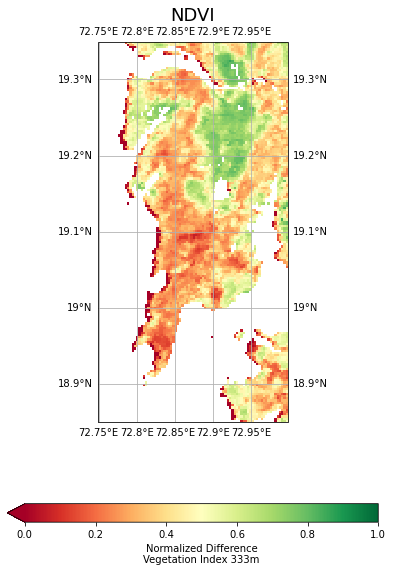

In [18]:
fig = plt.figure(1, figsize=[7, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
#ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
#ax.add_feature(cfeature.OCEAN, zorder=100)

# We need to project our data to the new Orthographic projection and for this we use `transform`.
# we set the original data projection in transform (here Mercator)
ndvi.where(ndvi['NDVI'] < ndvi['NDVI'].max()).sel(time="2021-01-01").sel(latitude=slice(19.35, 18.85), longitude=slice(72.75, 73.))['NDVI'].plot(
    ax=ax, transform=ccrs.PlateCarree(), cmap='RdYlGn',
    cbar_kwargs={'orientation':'horizontal','shrink':0.95}, vmin=0, vmax=1)

# One way to customize your title
plt.title("NDVI", fontsize=18)

### Same plot but with hvplot

In [19]:
ndvi.where(ndvi['NDVI'] < ndvi['NDVI'].max()).sel(time='2021-01-01').squeeze().NDVI.hvplot('longitude', 'latitude', cmap='RdYlGn',  width=800, height=700)

:Image   [longitude,latitude]   (NDVI)

### Compare NDVI long-term statistics on a single location

In [20]:
lat = 19.26
lon = 72.8

Text(0.5, 1.0, 'Map of the area of interest')

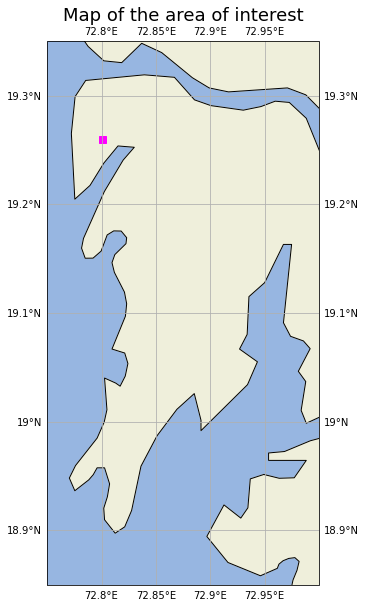

In [21]:
fig = plt.figure(1, figsize=[15, 10])

# We're using cartopy and are plotting in PlateCarree projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([72.75, 73., 19.35, 18.85], crs=ccrs.PlateCarree()) # lon1 lon2 lat1 lat2
ax.coastlines(resolution='10m')
ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)

plt.plot(lon, lat,
         color='magenta', markersize=7, marker='s',
         transform=ccrs.PlateCarree(),
         )

# One way to customize your title
plt.title("Map of the area of interest", fontsize=18)

Text(0.5, 1.0, 'NDVI')

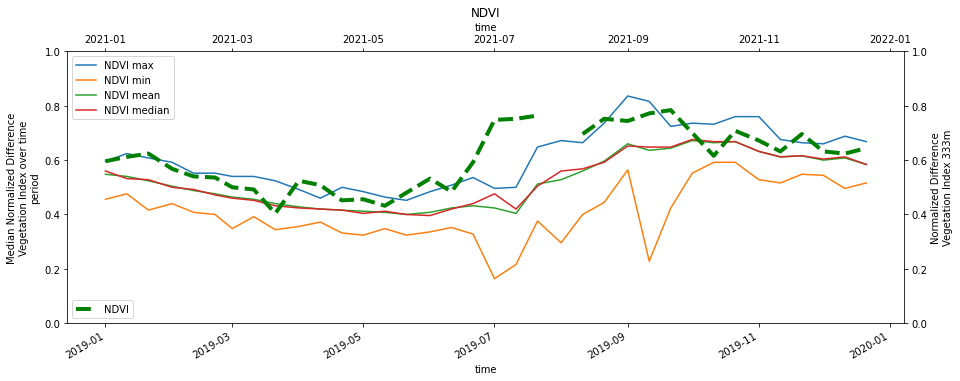

In [22]:
fig = plt.figure(1, figsize=[15, 5])
ax1=fig.add_subplot(111)
ax2=fig.add_subplot(111, frame_on=False)
p = {}
for stat in ['max', 'min', 'mean', 'median']:
    p[stat] = ndvi_LTS[stat].sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2019-01-01', '2019-12-31'))['NDVI_' + stat].plot(ax=ax1)

ax1.legend((p['max'], p['min'], p['mean'], p['median']) , labels=('NDVI max', 'NDVI min', 'NDVI mean', 'NDVI median'), loc = 'upper left')
ax1.set_ylim([0, 1])
ax1.set_title("")

ps = ndvi.sel(latitude=lat, longitude=lon, method='nearest').sel(time=slice('2021-01-01', '2021-12-31'))['NDVI'].plot(ax=ax2, color='green', 
                                                                                                                      linestyle='dashed', 
                                                                                                                      linewidth=4)
ax2.legend([ps], labels=['NDVI'], loc = 'lower left')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim([0, 1])
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
ax2.set_title("")
plt.title("NDVI")